In [52]:
# libraries

# data processing
import pandas as pd
import geopandas as gpd
import numpy as np
import carto2gpd

# graphics
from matplotlib import pyplot as plt
import hvplot.pandas

# census
import cenpy

# bus ridership data
from sodapy import Socrata

In [53]:
acs = cenpy.remote.APIConnection("ACSDT5Y2019")

# get block group gemetry from census data
# set geo server
acs.set_mapservice("tigerWMS_ACS2019")

# Use SQL to return geometries only for Philadelphia, PA
where_clause = f"STATE = {'42'} AND COUNTY = {'101'}"

# Query for block groups
philly_bg = acs.mapservice.layers[10].query(where=where_clause)

# review the first few rows of block groups in cook county
philly_bg.head()

C:\Users\m1861\miniconda3\envs\musa-550-fall-2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


MTFCC             OID         GEOID STATE COUNTY   TRACT BLKGRP BASENAME  \
0  G5030  20859508776554  421010090004    42    101  009000      4        4   
1  G5030  20859508883786  421010188002    42    101  018800      2        2   
2  G5030  20859508883559  421010382002    42    101  038200      2        2   
3  G5030  20859508934956  421010090001    42    101  009000      1        1   
4  G5030  20859508776526  421010090002    42    101  009000      2        2   

            NAME LSADC FUNCSTAT  AREALAND  AREAWATER      CENTLAT  \
0  Block Group 4    BG        S    127839          0  +39.9572985   
1  Block Group 2    BG        S     59722          0  +39.9975515   
2  Block Group 2    BG        S    250653          0  +39.9901972   
3  Block Group 1    BG        S     67291          0  +39.9616601   
4  Block Group 2    BG        S     83926          0  +39.9597607   

        CENTLON     INTPTLAT      INTPTLON  OBJECTID  \
0  -075.1914596  +39.9572985  -075.1914596      3312   
1  -075.1023594  +39.9975515  -075.1023594      3294   
2  -075.1026825  +39.9901972  -075.1026825      3295   
3  -075.1923616  +39.9616601  -075.1923616      3741   
4  -075.1914912  +39.9597607  -075.1914912      3742   

                                            geometry  
0  POLYGON ((-8370567.253 4859618.633, -8370565.4...  
1  POLYGON ((-8360576.329 4865634.793, -8360515.3...  
2  POLYGON ((-8360910.732 4864437.488, -8360638.5...  
3  POLYGON ((-8370579.498 4860512.096, -8370429.3...  
4  POLYGON ((-8370547.215 4860205.940, -8370524.1...

In [54]:
# calculate the total area of each block group
philly_bg["TOTALAREA"] = philly_bg.area

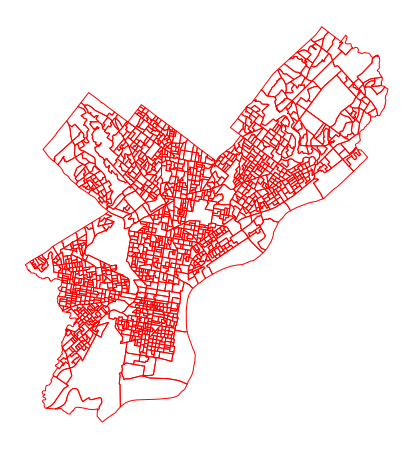

In [55]:
# plot the city boundary geometry for philly (city and county are the same)
fig, ax = plt.subplots(figsize=(8, 8))
philly_bg.plot(ax=ax, facecolor='none', edgecolor='red')
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

In [56]:
# listing socioeconomics variables from 2019 5-year acs - same as the variables for Chicago
variables = [
    "NAME",
    "B01003_001E", # total pop
    "B25064_001E", # median rent
    "B19113_001E", # median income
    "B01002_001E", # median age
    "B15003_001E", # educational attainment for the pop 25 and over 
    "B15003_022E", # total bachelor's degree
    "B15003_023E", # master's degree                    
    "B15003_024E", # professional degree
    "B15003_025E", # doctoral
    "B08012_001E", # total commuters
    "B08012_002E", # commute < 5
    "B08012_003E", # 5  < commute < 9
    "B08012_004E", # 10 < commute < 14
    "B08012_005E", # 15 < commute < 19
    "B08012_006E", # 20 < commute < 24
    "B08012_007E", # 25 < commute < 29
    "B08012_008E", # 30 < commute < 34                   
    "B08012_009E", # 35 < commute < 39
    "B08012_010E", # 40 < commute < 44
    "B08012_011E", # 45 < commute < 59
    "B08012_012E", # 60 < commute < 89
    "B08012_013E", # 90 < commute
    "B02001_002E", # white
    "B02001_003E", # african american
    "B01001F_002E", # male
    "B01001F_017E", # female
    "B08006_004E", # carpooled                      
    "B08201_001E", # total household
    "B08201_002E", # household without vehicles
    "B25003_002E", # tenure: owner
    "B06008_001E", # total marriagestatus
    "B06008_002E", # single                     
    "B06008_004E", # divorced
    "B09018_002E", # with children
    "B25027_002E",  # household with mortgage
    "GEO_ID"
]

In [57]:
# query from the cenpy api
philly_data = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": "42", 
                "county": "101", 
                "tract": "*"},
)

In [58]:
# rename the columns for easier references
dict = {"NAME": "NAME",
    "B01003_001E": "total_pop",
    "B25064_001E": "median_rent",
    "B19113_001E": "median_income",
    "B01002_001E": "median_age",
    "B15003_001E": "educational_attainment_pop25" ,
    "B15003_022E": "bachelor_degree",
    "B15003_023E": "master_degree"  ,                  
    "B15003_024E": "professional_degree",
    "B15003_025E": "doctoral_degree",
    "B08012_001E": "total_commuters",
    "B08012_002E": "commute_0-5",
    "B08012_003E": "commute_5-9",
    "B08012_004E": "commute_10-14",
    "B08012_005E": "commute_15-19",
    "B08012_006E": "commute_20-24",
    "B08012_007E": "commute_25-29",
    "B08012_008E": "commute_30-34",                  
    "B08012_009E": "commute_35-39",
    "B08012_010E": "commute_40-44",
    "B08012_011E": "commute_45-59",
    "B08012_012E": "commute_60-89",
    "B08012_013E": "commute_90-inf",
    "B02001_002E": "white",
    "B02001_003E": "african_american",
    "B01001F_002E": "male",
    "B01001F_017E": "female",
    "B08006_004E": "carpooled"  ,                    
    "B08201_001E": "total_household",
    "B08201_002E": "household_without_vehicles",
    "B25003_002E": "tenure_owner",
    "B06008_001E": "total_marriagestatus",
    "B06008_002E": "single",                   
    "B06008_004E": "divorced",
    "B09018_002E": "with_children",
    "B25027_002E": "household_with_mortgage",
    "GEO_ID": "GEO_ID"}

philly_data.rename(columns=dict, inplace=True)

# review the dataset
philly_data

NAME total_pop median_rent  \
0     Block Group 1, Census Tract 9807, Philadelphia...         0  -666666666   
1     Block Group 3, Census Tract 27.01, Philadelphi...      1955        1278   
2     Block Group 2, Census Tract 337.01, Philadelph...       976        1009   
3     Block Group 3, Census Tract 337.01, Philadelph...      3859         941   
4     Block Group 2, Census Tract 205, Philadelphia ...      1017         247   
...                                                 ...       ...         ...   
1331  Block Group 1, Census Tract 215, Philadelphia ...       997        1642   
1332  Block Group 1, Census Tract 216, Philadelphia ...       998        1146   
1333  Block Group 2, Census Tract 27.01, Philadelphi...      1232        1124   
1334  Block Group 1, Census Tract 9806, Philadelphia...         0  -666666666   
1335  Block Group 1, Census Tract 337.01, Philadelph...      1754  -666666666   

     median_income    median_age educational_attainment_pop25 bachelor_degree  \
0       -666666666  -666666666.0                            0               0   
1            56399          31.0                         1376             321   
2            41991          34.1                          781             160   
3            59911          44.0                         2561             451   
4            42036          64.6                          929              37   
...            ...           ...                          ...             ...   
1331         69321          31.3                          605             236   
1332         99792          38.7                          740             192   
1333         49261          36.2                         1016             221   
1334    -666666666  -666666666.0                            0               0   
1335    -666666666          37.1                         1059             164   

     master_degree professional_degree doctoral_degree total_commuters  \
0                0                   0               0            None   
1              216                  22               8            None   
2                0                  48               0            None   
3              156                  91              25            None   
4               36                  41               0            None   
...            ...                 ...             ...             ...   
1331            73                  13              11            None   
1332           111                  42              10            None   
1333           118                  11               0            None   
1334             0                   0               0            None   
1335           149                  21               0            None   

     commute_0-5 commute_5-9 commute_10-14 commute_15-19 commute_20-24  \
0           None        None          None          None          None   
1           None        None          None          None          None   
2           None        None          None          None          None   
3           None        None          None          None          None   
4           None        None          None          None          None   
...          ...         ...           ...           ...           ...   
1331        None        None          None          None          None   
1332        None        None          None          None          None   
1333        None        None          None          None          None   
1334        None        None          None          None          None   
1335        None        None          None          None          None   

     commute_25-29 commute_30-34 commute_35-39 commute_40-44 commute_45-59  \
0             None          None          None          None          None   
1             None          None          None          None          None   
2             None          None          None          None          None   
3             N

In [59]:
# getting the GEOID for spatial join
philly_data["GEOID"] = [x[9:] for x in philly_data['GEO_ID']]
# review the first few rows of the dataset
philly_data['GEOID']

philly_data

NAME total_pop median_rent  \
0     Block Group 1, Census Tract 9807, Philadelphia...         0  -666666666   
1     Block Group 3, Census Tract 27.01, Philadelphi...      1955        1278   
2     Block Group 2, Census Tract 337.01, Philadelph...       976        1009   
3     Block Group 3, Census Tract 337.01, Philadelph...      3859         941   
4     Block Group 2, Census Tract 205, Philadelphia ...      1017         247   
...                                                 ...       ...         ...   
1331  Block Group 1, Census Tract 215, Philadelphia ...       997        1642   
1332  Block Group 1, Census Tract 216, Philadelphia ...       998        1146   
1333  Block Group 2, Census Tract 27.01, Philadelphi...      1232        1124   
1334  Block Group 1, Census Tract 9806, Philadelphia...         0  -666666666   
1335  Block Group 1, Census Tract 337.01, Philadelph...      1754  -666666666   

     median_income    median_age educational_attainment_pop25 bachelor_degree  \
0       -666666666  -666666666.0                            0               0   
1            56399          31.0                         1376             321   
2            41991          34.1                          781             160   
3            59911          44.0                         2561             451   
4            42036          64.6                          929              37   
...            ...           ...                          ...             ...   
1331         69321          31.3                          605             236   
1332         99792          38.7                          740             192   
1333         49261          36.2                         1016             221   
1334    -666666666  -666666666.0                            0               0   
1335    -666666666          37.1                         1059             164   

     master_degree professional_degree doctoral_degree total_commuters  \
0                0                   0               0            None   
1              216                  22               8            None   
2                0                  48               0            None   
3              156                  91              25            None   
4               36                  41               0            None   
...            ...                 ...             ...             ...   
1331            73                  13              11            None   
1332           111                  42              10            None   
1333           118                  11               0            None   
1334             0                   0               0            None   
1335           149                  21               0            None   

     commute_0-5 commute_5-9 commute_10-14 commute_15-19 commute_20-24  \
0           None        None          None          None          None   
1           None        None          None          None          None   
2           None        None          None          None          None   
3           None        None          None          None          None   
4           None        None          None          None          None   
...          ...         ...           ...           ...           ...   
1331        None        None          None          None          None   
1332        None        None          None          None          None   
1333        None        None          None          None          None   
1334        None        None          None          None          None   
1335        None        None          None          None          None   

     commute_25-29 commute_30-34 commute_35-39 commute_40-44 commute_45-59  \
0             None          None          None          None          None   
1             None          None          None          None          None   
2             None          None          None          None          None   
3             N

In [60]:
# merge the philly block group gemoetry with socioeconomic variables by GEOID
philly_data = philly_bg.merge(philly_data, on = "GEOID") 
# drop unused columns
pd.set_option("display.max_columns", None)
philly_data = philly_data.drop(labels=['MTFCC', 'NAME_x'], axis=1)
philly_data['NAME'] = philly_data['NAME_y']
#philly_data['geometry'] = philly_data['geometry_y']
# only include same varables as Chicago's
chicago_vars = ['GEOID', 'geometry', 'NAME', 'total_pop', 'median_rent',
       'median_income', 'median_age', 'educational_attainment_pop25',
       'bachelor_degree', 'master_degree', 'professional_degree',
       'doctoral_degree', 'total_commuters', 'commute_0-5', 'commute_5-9',
       'commute_10-14', 'commute_15-19', 'commute_20-24', 'commute_25-29',
       'commute_30-34', 'commute_35-39', 'commute_40-44', 'commute_45-59',
       'commute_60-89', 'commute_90-inf', 'white', 'african_american', 'male',
       'female', 'carpooled', 'total_household', 'household_without_vehicles',
       'tenure_owner', 'total_marriagestatus', 'single', 'divorced',
       'with_children', 'household_with_mortgage', 'GEO_ID', 'state', 'county',
       'tract', 'block group']
philly_data = philly_data[chicago_vars]
# review dataset
philly_data

GEOID                                           geometry  \
0     421010090004  POLYGON ((-8370567.253 4859618.633, -8370565.4...   
1     421010188002  POLYGON ((-8360576.329 4865634.793, -8360515.3...   
2     421010382002  POLYGON ((-8360910.732 4864437.488, -8360638.5...   
3     421010090001  POLYGON ((-8370579.498 4860512.096, -8370429.3...   
4     421010090002  POLYGON ((-8370547.215 4860205.940, -8370524.1...   
...            ...                                                ...   
1331  421010008034  POLYGON ((-8368347.542 4858540.834, -8368339.4...   
1332  421010007001  POLYGON ((-8368604.022 4858853.474, -8368594.3...   
1333  421010309001  POLYGON ((-8358600.630 4873108.864, -8358553.6...   
1334  421010318001  POLYGON ((-8357969.449 4870645.571, -8357961.9...   
1335  421010369003  POLYGON ((-8370742.581 4859264.582, -8370729.2...   

                                                   NAME total_pop median_rent  \
0     Block Group 4, Census Tract 90, Philadelphia C...      1970        1187   
1     Block Group 2, Census Tract 188, Philadelphia ...      1290        1143   
2     Block Group 2, Census Tract 382, Philadelphia ...      1029        1100   
3     Block Group 1, Census Tract 90, Philadelphia C...       455         983   
4     Block Group 2, Census Tract 90, Philadelphia C...      2273        1288   
...                                                 ...       ...         ...   
1331  Block Group 4, Census Tract 8.03, Philadelphia...       376        1350   
1332  Block Group 1, Census Tract 7, Philadelphia Co...       931        1796   
1333  Block Group 1, Census Tract 309, Philadelphia ...      1570        1167   
1334  Block Group 1, Census Tract 318, Philadelphia ...      1370         987   
1335  Block Group 3, Census Tract 369, Philadelphia ...      4099        2471   

     median_income median_age educational_attainment_pop25 bachelor_degree  \
0       -666666666       19.6                          232              36   
1            47926       27.9                          807              33   
2            48636       39.0                          712              98   
3           106094       25.3                          231              79   
4       -666666666       19.3                          160              77   
...            ...        ...                          ...             ...   
1331        250001       70.3                          359             112   
1332    -666666666       46.8                          925             248   
1333         50982       34.4                          994              70   
1334         45875       37.4                          876             178   
1335    -666666666       21.2                          768             240   

     master_degree professional_degree doctoral_degree total_commuters  \
0               92                  22               0            None   
1               16                   0               0            None   
2               19                   0               5            None   
3               81                   8              36            None   
4               13                   0               0            None   
...            ...                 ...             ...             ...   
1331           123                 101              23            None   
1332           155                 168              62            None   
1333             7                   0               0            None   
1334            35                  10               0            None   
1335           137                  62              80            None   

     commute_0-5 commute_5-9 commute_10-14 commute_15-19 commute_20-24  \
0           None        None          None          None          None   
1           None        None          None          None          None   
2           None        None          None          None          None   
3           None        None          Non

In [61]:
philly_data.columns

Index(['GEOID', 'geometry', 'NAME', 'total_pop', 'median_rent',
       'median_income', 'median_age', 'educational_attainment_pop25',
       'bachelor_degree', 'master_degree', 'professional_degree',
       'doctoral_degree', 'total_commuters', 'commute_0-5', 'commute_5-9',
       'commute_10-14', 'commute_15-19', 'commute_20-24', 'commute_25-29',
       'commute_30-34', 'commute_35-39', 'commute_40-44', 'commute_45-59',
       'commute_60-89', 'commute_90-inf', 'white', 'african_american', 'male',
       'female', 'carpooled', 'total_household', 'household_without_vehicles',
       'tenure_owner', 'total_marriagestatus', 'single', 'divorced',
       'with_children', 'household_with_mortgage', 'GEO_ID', 'state', 'county',
       'tract', 'block group'],
      dtype='object')

In [62]:
# converting strings to numeric input
for variable in philly_data.columns:
    
    # Convert all variables
    if variable != "NAME" and variable != "GEO_ID" and variable != "geometry" and variable != "GEOID":
        philly_data[variable] = philly_data[variable].astype(float)